In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
from tslearn.utils import to_time_series, to_time_series_dataset
from tslearn.metrics import dtw

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve
from sklearn.pipeline import Pipeline

from automltsad.detectors import TrivialDetector, KNN, WindowingDetector, IsolationForestAD, LOF
from automltsad.transform import MeanVarianceScaler
from automltsad.utils import sliding_window_sequences, reduce_window_scores
from automltsad.metrics import average_precision_score, roc_auc_score, f1_pa, f1_pa_auc_score, f1_pa_curve

import optuna

warnings.filterwarnings('ignore')

# _LOGGER = logging.getLogger('automltsad')
# _LOGGER.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter(
#     '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
# )
# ch.setFormatter(formatter)
# _LOGGER.addHandler(ch)


In [9]:
file_id = 3
sorted(os.listdir('./data'))[file_id]

'004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt'

In [10]:
file = sorted(os.listdir('./data'))[file_id]
test_start, anomaly_start, anomaly_end = [
    int(i) for i in file.split('.')[0].split('_')[-3:]
]
a = np.loadtxt(f'./data/{file}')
a = to_time_series_dataset(a)

train = a[:,:test_start]
test = a[:,test_start:]
label = np.zeros_like(test)
label[:,anomaly_start-test_start:anomaly_end-test_start] = 1
label = np.squeeze(label)



In [31]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [32]:
def objective(trial):
    det = WindowingDetector(
        KNN(
            n_neighbors= trial.suggest_int('n_neighbors',4,32, log=True)
        ),
        window_size = trial.suggest_int('window_size',16,512, log=True),
        standardize=True
    )
    det.fit(train)
    anomaly_scores = det.predict_anomaly_scores(test)
    p, r, t = precision_recall_curve(label, anomaly_scores)
    f1 = 2*p*r / (p+r)
    idx = np.argmax(f1)
    
    return f1[idx] if f1[idx] else 0

study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction='maximize')
study.optimize(objective, n_trials=100)

[W 2023-01-07 16:10:47,016] Trial 4 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:11:33,233] Trial 37 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:11:35,943] Trial 39 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:11:37,261] Trial 40 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:11:44,194] Trial 45 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:11:46,876] Trial 47 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:12:06,402] Trial 61 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:12:11,796] Trial 65 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:12:17,514] Trial 69 failed because of the following error: The value nan is not acceptable.
[W 2023-01-07 16:12:

In [23]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [33]:
plot_optimization_history(study)

In [34]:
plot_parallel_coordinate(study)

In [35]:
plot_contour(study)

In [140]:

# trainw = sliding_window_sequences(train, 8)
# trainw.shape
# s = MeanVarianceScaler()
# s.fit(trainw)
# s.transform(trainw)

# n_s, n_t, _ = trainw.shape
# trainw = trainw.reshape(n_s, n_t)

# n_s, n_t, _ = testw.shape
# testw = testw.reshape(n_s, n_t)


# slr = TimeSeriesScalerMeanVariance()



# test_labels = det.predict(testw)

# scl_train = slr.fit_transform(train)
# det.fit(scl_train)
# scl_test = slr.transform(test)
# scores = det.predict_anomaly_scores(scl_test)

0.8727992132515601


0.7987987987987988

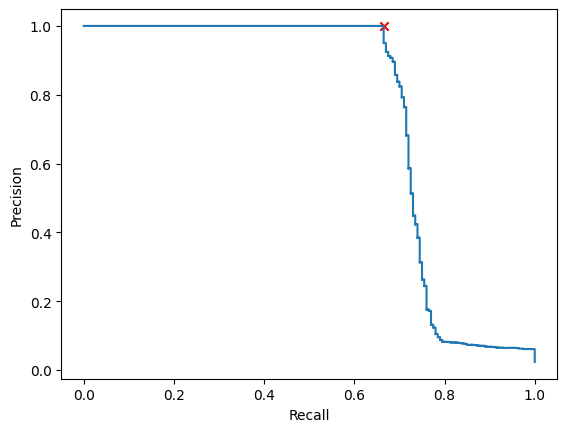

In [141]:
p, r, t = precision_recall_curve(label, anomaly_scores)
f1 = 2*p*r / (p+r)
idx = np.argmax(f1)
PrecisionRecallDisplay(p, r).plot()
plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
best_t = t[idx]
best_f1 = f1[idx]
print(t[idx])
f1[idx]


In [142]:
f1_pa(label, anomaly_scores, best_t, k=0)

1.0

In [143]:
f1_pa_auc_score(label, anomaly_scores, best_t)

0.9283132530120483

(0.0, 1.0)

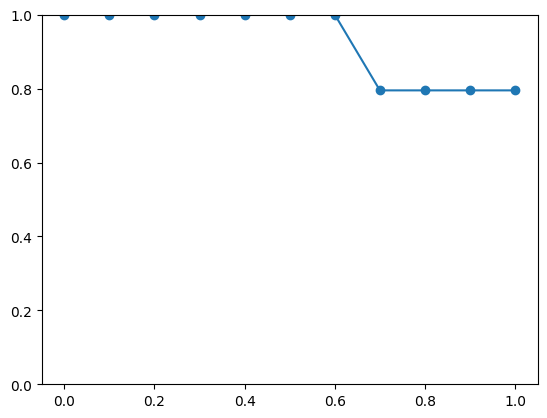

In [144]:
x, y = f1_pa_curve(label, anomaly_scores, best_t)
plt.plot(x, y, marker='o')
plt.ylim(0,1)

In [145]:
roc_auc_score(label, anomaly_scores)

0.9335228915662651

In [146]:
average_precision_score(label, anomaly_scores)

0.7464619597883714

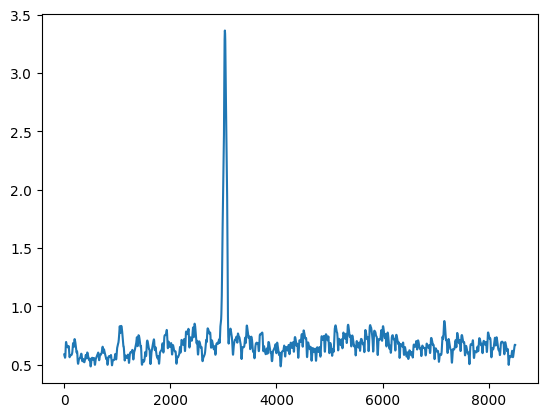

In [147]:
plt.plot(anomaly_scores)

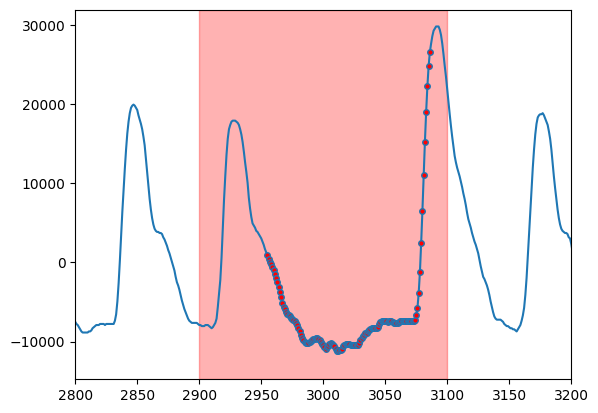

In [148]:
plt.plot(test[0], markevery=(anomaly_scores>best_t).reshape(-1).nonzero()[0], **dict(ms=4, marker='o', markerfacecolor='red'))
plt.xlim(anomaly_start-test_start - 100, anomaly_end-test_start + 100)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()